# Milestone: LightGCN Course Recommender
Borrows code from Hikaru Hotta and Ada Zhou, https://medium.com/stanford-cs224w/lightgcn-with-pytorch-geometric-91bab836471e

In [1]:
import json
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling, negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing

## Load Dataset

In [2]:
with open('new_planned_courses.json') as f:
    planned_courses = json.load(f)
course_counter = {}

# Iterating through each student's data to count enrollments and courses, excluding 'Unplanned'
for student, quarters in planned_courses.items():
    for quarter, courses in quarters.items():
        if (quarter != 'None'):
            # Counting course frequency
            for course in courses:
                if course== 'RESTRICTED':
                    continue
                if not (course in course_counter):
                    course_counter[course] = 1
                else:
                    course_counter[course] += 1  
                    
# course_counter
min_enrollments_thre = 4
course_count_df = pd.DataFrame(course_counter.items(), columns=['Course', 'Enrollments'])
course_count_df = course_count_df.drop(index=course_count_df[course_count_df.Enrollments < min_enrollments_thre].index)
selected_courses = list(course_count_df.Course)

In [3]:
userIds = {}
courseIds = {}
numEdges = 0
min_courses_thre = 4

# clean up data, create userIds and courseIds
num_course_each_student = []
Ids = []

for user in list(planned_courses.keys()):
    
    # Pt.1 we count the total amount of courses each user already took
    # and we get rid of the users with only a few course pinned
    num = 0
    for quarter in planned_courses[user]:
        num += len(planned_courses[user][quarter])
    
    if num < min_courses_thre:
        del planned_courses[user]
        continue
    else:
        userIds[user] = len(userIds)
    
    #Pt.2 build the userIds and CourseIds dict
    for quarter in planned_courses[user]:
        numEdges += len(planned_courses[user][quarter])
        for course in planned_courses[user][quarter]:
            if course== 'RESTRICTED' or (course not in selected_courses):
                numEdges -= 1
                continue
            if (course not in courseIds) :
                courseIds[course] = len(courseIds)
    Ids.append(len(userIds))
    num_course_each_student.append(num)

#The course' IDs will be followed after the user's IDs

for item in courseIds:
    courseIds[item] += len(userIds)

print('# of real users:', len(userIds))
print('# of courses:', len(courseIds))
print('# of edges:', numEdges)

# of real users: 1895
# of courses: 1518
# of edges: 27086


In [5]:
# create edge_index
j = 0
edge_index = torch.zeros((2, numEdges), dtype=int)
train_edge_index = []
val_edge_index_sup = []

for user in planned_courses:
    user_edge_index = []
    for quarter in planned_courses[user]:
        for course in planned_courses[user][quarter]:
            if (course== 'RESTRICTED') or (course not in selected_courses):
                continue
            edge_index[0][j] = userIds[user]
            edge_index[1][j] = courseIds[course]
            user_edge_index.append((userIds[user], courseIds[course]))
            j += 1
            
    # Here we split 
    user_num_courses = len(user_edge_index)
    user_train_indices = random.sample([i for i in range(user_num_courses)], k=int(0.8*user_num_courses))
    user_val_indices = list(set([i for i in range(user_num_courses)]) - set(user_train_indices))
    train_edge_index += [user_edge_index[i] for i in user_train_indices]
    val_edge_index_sup += [user_edge_index[i] for i in user_val_indices]
    
train_edge_index = torch.tensor(train_edge_index).T
val_edge_index_sup = torch.tensor(val_edge_index_sup).T
val_edge_index_msg = train_edge_index
train_edge_index.shape, val_edge_index_sup.shape

(torch.Size([2, 20991]), torch.Size([2, 6095]))

In [6]:
# split the edges of the graph using a 80/20 train/validation split
num_users, num_courses = len(userIds), len(courseIds)
numNodes = num_users + num_courses
# all_edge_indices = [i for i in range(numEdges)]

# train_edge_indices, val_edge_indices_sup = train_test_split(all_edge_indices, test_size=0.2, random_state=1)
# # the validation msg is supposed to be the entire training edge set. 
# # we'll be dividing the training edge set into msg set and sup set later
# val_edge_indices_msg = train_edge_indices

# train_edge_index = edge_index[:, train_edge_indices]
# val_edge_index_msg   = edge_index[:, val_edge_indices_msg]
# val_edge_index_sup   = edge_index[:, val_edge_indices_sup]

train_sparse_edge_index = SparseTensor(row=train_edge_index[0], 
                                       col=train_edge_index[1], 
                                       sparse_sizes=(numNodes, numNodes))
val_sparse_edge_index_msg = SparseTensor(row=val_edge_index_msg[0], 
                                         col=val_edge_index_msg[1], 
                                         sparse_sizes=(numNodes, numNodes))
val_sparse_edge_index_sup = SparseTensor(row=val_edge_index_sup[0], 
                                         col=val_edge_index_sup[1], 
                                         sparse_sizes=(numNodes, numNodes))

In [7]:
# function which random samples a mini-batch of positive and negative samples
edge_set = set([tuple(edge) for edge in edge_index.t().tolist()])
    
def negative_sampling(edge_index, num_users, num_items, neg_per_person=1):

    # Prepare for negative sampling
    # Detect non-isolated users and items
    # non_isolated_users = set(edge_index[0].tolist())
    # non_isolated_items = set(edge_index[1].tolist())
    negative_edges = []
    for j in range(neg_per_person):
        for i in range(len(edge_index[0])):
            user = edge_index[0,i]
            pos_item = edge_index[1, i]
            # Sample negative items for each user
            while True:
                negative_item = random.randint(num_users, num_users + num_items - 1)
                # if negative_item not in non_isolated_items:
                #     continue  # Skip isolated items
                if (user, negative_item) not in edge_set:
                    negative_edges.append([user, pos_item, negative_item])
                    break

    return torch.tensor(negative_edges).t()


def sample_mini_batch(batch_size, edge_index, negative_edges):
    """Randomly samples indices of a minibatch given an adjacency matrix

    Args:
        batch_size (int): minibatch size
        edge_index (torch.Tensor): 2 by N list of edges
        negative_edges (torch.Tensor): 3 by N list of edges, 
                0-user indices, 1-positive item indices, 2-negative item indices

    Returns:
        tuple: user indices, positive item indices, negative item indices
    """
    
    # if we have already done the negative sampling somewhere else we kip this part
    # otherwise we need to do the negative smapling
    if negative_edges is None:
        negative_edges = negative_sampling(train_edge_index, num_users=num_courses, num_items=num_courses)

    # get a mini_batch of it
    indices = random.sample([i for i in range(len(negative_edges[0]))], k=batch_size)
    batch = negative_edges[:, indices]
    
    # Node, all of the courseIds are followed by the userIds
    # So for convenience, we subtract the courseIds by num_users 
    # so that courseIds are from 0 to num_courses, which helps with extracting the course embeddings
    user_indices, pos_item_indices, neg_item_indices= batch[0], batch[1] - num_users, batch[2] - num_users
    
    return user_indices, pos_item_indices, neg_item_indices

## Load Embeddings

In [8]:
# embeddings

In [9]:
import pickle
with open('embeddings32_2023-12-09.pkl', 'rb') as f:
    embeddings = pickle.load(f)
    
embedding_length = len(embeddings['CS224W'])

In [10]:
embeddings_mat = np.zeros((num_courses, embedding_length))
course_no_info = []
print('Courses without embeddings')
for one_course in courseIds:
    if one_course not in embeddings:
        print(one_course)
        course_no_info.append(courseIds[one_course]-num_users)
        continue
    # if one_course == 'CS144':
    #     print(courseIds[one_course]-num_users)
    embeddings_mat[courseIds[one_course]-num_users] = np.array(embeddings[one_course])
embeddings_mat = torch.tensor(embeddings_mat)

# For those courses without embeddings, use the averaged embedding of all course as their embeddings
ave = torch.mean(embeddings_mat, axis=0)
embeddings_mat[course_no_info] = ave
embeddings_mat = embeddings_mat.type(torch.float32)

# Normalize the data. The embeddings we have are aleady 0 mean
embeddings_mat = embeddings_mat/embeddings_mat.std()

Courses without embeddings
ME110
GEOLSCI1
PHYSICS40


## Model

In [11]:
# defines LightGCN model
class LightGCN(MessagePassing):
    """LightGCN Model as proposed in https://arxiv.org/abs/2002.02126
    """

    def __init__(self, num_users, num_items, course_ada_emb=embeddings_mat, embedding_dim=64, K=3, add_self_loops=False):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops
        self.cours_ada_emb = course_ada_emb
        ada_emb_len = course_ada_emb.shape[-1]
        
        # pre_diffusion embedding will be used for regularization computing
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0
        self.emb_transform = nn.Sequential(nn.Linear(in_features=ada_emb_len, out_features=embedding_dim),
                                           nn.GELU(),
                                           nn.LayerNorm(embedding_dim),
                                           nn.Linear(in_features=embedding_dim, out_features=embedding_dim),
                                           nn.GELU(),
                                           nn.LayerNorm(embedding_dim))
        self.score_mat = nn.Parameter(torch.eye(embedding_dim),requires_grad=False)
        
        # embedding after multi-scale diffusion
        # this will be used to give final recommendation/compute brp loss
        self.users_emb_final = None
        self.items_emb_final = None
        

        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: SparseTensor, weight=1):
        """Forward propagation of LightGCN Model.

        Args:
            edge_index (SparseTensor): adjacency matrix

        Returns:
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """
        # compute \tilde{A}: symmetrically normalized adjacency matrix
        edge_index_norm = gcn_norm(edge_index, add_self_loops=self.add_self_loops)
        
        course_ada_emb = self.emb_transform(self.cours_ada_emb)
        course_emb = course_ada_emb * weight + self.items_emb.weight

        emb_0 = torch.cat([self.users_emb.weight, course_emb]) # E^0
        embs = [emb_0]
        emb_k = emb_0

        # multi-scale diffusion
        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k)
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1) # E^K

        users_emb_final, items_emb_final = torch.split(emb_final, [self.num_users, self.num_items]) # splits into e_u^K and e_i^K
        
        self.users_emb_final = users_emb_final
        self.items_emb_final = items_emb_final
        # rating_mat = torch.matmul(users_emb_final, items_emb_final.T)
        # returns the embedding of both the original and after multiscale diffusion
        
        return users_emb_final, self.users_emb.weight, items_emb_final,  self.items_emb.weight

    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        # computes \tilde{A} @ x
        return matmul(adj_t, x)

In [12]:
def bpr_loss(model, users_emb_final, users_emb_0, 
             pos_items_emb_final, pos_items_emb_0, 
             neg_items_emb_final, neg_items_emb_0, lambda_val):
    """Bayesian Personalized Ranking Loss as described in https://arxiv.org/abs/1205.2618

    Args:
        users_emb_final (torch.Tensor): e_u_k
        users_emb_0 (torch.Tensor): e_u_0
        pos_items_emb_final (torch.Tensor): positive e_i_k
        pos_items_emb_0 (torch.Tensor): positive e_i_0
        neg_items_emb_final (torch.Tensor): negative e_i_k
        neg_items_emb_0 (torch.Tensor): negative e_i_0
        lambda_val (float): lambda value for regularization loss term

    Returns:
        torch.Tensor: scalar bpr loss value
    """
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # L2 loss
    epsilon = 1e-7
    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    # pos_scores = torch.trace(users_emb_final @ model.score_mat @ pos_items_emb_final.T)
    # pos_scores = weighted_dot_product(users_emb_final, pos_items_emb_final, model.score_mat)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    # neg_scores = torch.trace( users_emb_final @ model.score_mat @ neg_items_emb_final.T )
    # neg_scores = weighted_dot_product(users_emb_final, neg_items_emb_final, model.score_mat)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples

    # loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss
    loss = -torch.sum(torch.log(torch.sigmoid(pos_scores - neg_scores)+epsilon)) + reg_loss
    
    
#     pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
#     # pos_scores = users_emb_final @ model.score_mat @ pos_items_emb_final.T
#     pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
#     neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
#     # neg_scores = users_emb_final @ model.score_mat @ neg_items_emb_final.T
#     neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples

#     # loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss
#     loss2 = -torch.sum(torch.log(torch.sigmoid(pos_scores - neg_scores)))

    return loss

## Evaluation

In [13]:
# helper function to get N_u
def get_user_positive_items(edge_index):
    """Generates dictionary of positive items for each user

    Args:
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        dict: dictionary of positive items for each user
    """
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

In [14]:
# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    """Computers recall @ k and precision @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (intg): determines the top k items to compute precision and recall on

    Returns:
        tuple: recall @ k, precision @ k
    """
    num_correct_pred = torch.sum(r, dim=-1)  # number of correctly predicted items per user
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i]) for i in range(len(groundTruth))])
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [15]:
# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [16]:
# wrapper function to get evaluation metrics
def get_metrics(model, users_emb_final, items_emb_final, edge_index_msg, edge_index_sup, k):
    """Computes the evaluation metrics: recall, precision, and ndcg @ k

    Args:
        users_emb_final: usr emb after multi-scale diff
        items_emb_final: usr emb after multi-scale diff
        edge_index_msg (torch.Tensor): 2 by N list of edges for split to compute the emb
        edge_index_sup (torch.Tensor): 2 by N list of edges for split to supervise
        k (int): determines the top k items to compute metrics on

    Returns:
        tuple: recall @ k, precision @ k, ndcg @ k
    """

    # as in the intialize part, we add the courseIDs with num_Users for the convience of GNN training convience
    # here we subtract the num_Users for each courseIDs, for the convenience of emb extraction
    # As this varible edge_index will be send to the cpu/gpu, here this variable serves as an index of extracting 
    # emb, we don't want to change it so we clone it and then make modification
    edge_index_msg_cpy = edge_index_msg.clone()
    edge_index_sup_cpy = edge_index_sup.clone()
    edge_index_msg_cpy[1] -= num_users
    edge_index_sup_cpy[1] -= num_users
    
    all_indices = torch.concat((edge_index_msg_cpy, edge_index_sup_cpy), dim=1)
    user_indices_all = all_indices[0].unique()
    item_indices_all = all_indices[1].unique()
    
    #get ratings between every user and item - shape is num users x num movies
    rating = torch.matmul(users_emb_final, items_emb_final.T)
    # rating = users_emb_final @ model.score_mat @  items_emb_final.T
    # rating = weighted_dot_product(users_emb_final,items_emb_final, model.score_mat)
    # rating = users_emb_final @ model.score_mat @ items_emb_final.T
    # plt.imshow((torch.matmul(users_emb_final, items_emb_final.T) - rating).detach().numpy())
    
    # for recall/precision/ndcg computing, we exclude those message edges first
    exclude_edge_index = edge_index_msg_cpy
    #      gets all the positive items for each user from the edge index
    user_pos_items = get_user_positive_items(exclude_edge_index)
    #      get coordinates of all edges to exclude
    exclude_users = []
    exclude_items = []
    for user, items in user_pos_items.items():
        exclude_users.extend([user] * len(items))
        exclude_items.extend(items)

    #       set ratings of excluded edges to large negative value
    rating[exclude_users, exclude_items] = -(1 << 10)

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k=k)

    # get all unique users in evaluated split
    users = edge_index_sup_cpy[0,:].unique()

    test_user_pos_items = get_user_positive_items(edge_index_sup_cpy)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [17]:
def weighted_dot_product(A, B, W):
    # Reshape A and B for batch matrix multiplication
    A = A.unsqueeze(1)  # Shape: [N, 1, dim]
    B = B.unsqueeze(2)  # Shape: [M, dim, 1]

    # Apply the weight matrix
    weighted_A = torch.bmm(A, W.unsqueeze(0).expand(A.size(0), *W.size()))  # Shape: [N, 1, dim]

    # Perform the weighted dot product
    result = torch.bmm(weighted_A, B)  # Shape: [N, 1, 1]

    # Squeeze the result to get a [N] vector
    result = result.squeeze()  # Shape: [N]
    return result

In [18]:
# wrapper function to evaluate model
def evaluation(model, edge_index_msg, edge_index_sup, sparse_edge_index, k, lambda_val):
    """Evaluates model loss and metrics including recall, precision, ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index_msg: (torch.Tensor): 2 by N list of edges for split to compute final embedding
        edge_index_sup: (torch.Tensor): 2 by N list of edges for split to supervise
        sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate
        k (int): determines the top k items to compute metrics on
        lambda_val (float): determines lambda for bpr loss

    Returns:
        tuple: bpr loss, recall @ k, precision @ k, ndcg @ k
    """
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(sparse_edge_index)
    
    edges = negative_sampling(edge_index_msg, num_items=num_courses, num_users=num_users)
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1]-num_users, edges[2]-num_users
    users_emb_final_set, users_emb_0_set = users_emb_final[user_indices], users_emb_0[user_indices]
    
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(model, users_emb_final_set, users_emb_0_set, 
                    pos_items_emb_final, pos_items_emb_0,
                    neg_items_emb_final, neg_items_emb_0, lambda_val)
    
    # print(pos_items_emb_final.shape, users_emb_final_set.shape)

    recall, precision, ndcg = get_metrics(model, users_emb_final, items_emb_final, edge_index_msg, edge_index_sup, k)

    return loss.item(), recall, precision, ndcg

## Training

In [19]:
# define contants
ITERATIONS = 32001
BATCH_SIZE = 256
LR = 0.1
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
k = 20 #number of recommendations
LAMBDA = 1e-5
embedding_dim=32
K=5 #multiscale diffusion

# setup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index_msg = val_edge_index_msg.to(device)
val_edge_index_sup = val_edge_index_sup.to(device)
val_sparse_edge_index_msg = val_sparse_edge_index_msg.to(device)

Using device cpu.


In [20]:
from tqdm import tqdm
model = LightGCN(num_users, num_courses, course_ada_emb=embeddings_mat.to(device), embedding_dim=embedding_dim, K=K)
model = model.to(device)
model.train()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)

In [21]:
# training loop
train_msg_losses = []
train_losses = []
val_losses = []

train_ndcgs = []
val_ndcgs = []

train_recalls = []
val_recalls = []

train_precisions = []
val_precisions = []

print("@"+str(k)+" recommendation")
for iter in tqdm(range(ITERATIONS), desc='Training', leave=True):
    
    
    # Modified on Dec 2nd: Evaluate on train_sup set
    # forward propagation train_sparse_edge_msg_index
    if iter<0:
        weight = 0
    else: 
        weight = 1
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(train_sparse_edge_index, weight=weight)
    
    # mini batching
    # Modified on Dec 2nd: Evaluate on train_sup set
    if iter % ITERS_PER_EVAL == 0:
        # sample once, use the negative samples for multiple iterations
        negative_edges = negative_sampling(edge_index, num_users, num_courses, neg_per_person=10)
        
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, train_edge_index, negative_edges)
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    # loss computation
    train_msg_loss = bpr_loss(model, users_emb_final, users_emb_0, 
                              pos_items_emb_final, pos_items_emb_0, 
                              neg_items_emb_final, neg_items_emb_0, LAMBDA)

    optimizer.zero_grad()
    train_msg_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        
        #Modified on Dec 2nd: Evaluate on train_sup set
        length = train_edge_index.shape[1] - val_edge_index_sup.shape[1]
        temp_train_edge_msg = random.sample([i for i in range(len(train_edge_index[0]))], k=length)
        temp_train_edge_sup = list(set([i for i in range(len(train_edge_index[0]))]) - set(temp_train_edge_msg))
        temp_train_edge_msg = train_edge_index[:,temp_train_edge_msg]
        temp_train_edge_sup = train_edge_index[:,temp_train_edge_sup]
        temp_train_sparse_edge_msg = SparseTensor(row=temp_train_edge_msg[0], 
                                                  col=temp_train_edge_msg[1], sparse_sizes=(numNodes, numNodes))
        temp_train_sparse_edge_msg = temp_train_sparse_edge_msg.to(device)
        train_loss, train_recall, train_precision, train_ndcg = evaluation(model, 
                                                                           temp_train_edge_msg, 
                                                                           temp_train_edge_sup, 
                                                                           temp_train_sparse_edge_msg, 
                                                                           k, LAMBDA)
        
        val_loss, val_recall, val_precision, val_ndcg = evaluation(model, 
                                                                   val_edge_index_msg, 
                                                                   val_edge_index_sup, 
                                                                   val_sparse_edge_index_msg, 
                                                                   k, LAMBDA)
        
        
        l1 = f"[Iteration {iter}/{ITERATIONS}] train_msg_loss: {round(train_msg_loss.item(), 5)}, train_loss: {round(train_loss, 5)}, val_loss: {round(val_loss, 5)}"
        l2 = f"tr_re: {round(train_recall, 5)}, tr_pre: {round(train_precision, 5)}, tr_nd: {round(train_ndcg, 5)},"
        l3 = f"v_re: {round(val_recall, 5)}, v_pre: {round(val_precision, 5)}, v_nd: {round(val_ndcg, 5)},"

        print(l1)
        print(l2, l3)
        train_msg_losses.append(train_msg_loss.item())
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        train_ndcgs.append(train_ndcg)
        val_ndcgs.append(val_ndcg)
        
        train_recalls.append(train_recall)
        val_recalls.append(val_recall)
        
        train_precisions.append(train_precision)
        val_precisions.append(val_precision)
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

@20 recommendation


Training:   0%|          | 6/32001 [00:06<6:42:27,  1.32it/s] 

[Iteration 0/32001] train_msg_loss: 177.44472, train_loss: 10324.18945, val_loss: 14548.92188
tr_re: 0.01964, tr_pre: 0.00367, tr_nd: 0.01146, v_re: 0.01851, v_pre: 0.00292, v_nd: 0.00987,


Training:   1%|          | 209/32001 [00:16<2:33:08,  3.46it/s]

[Iteration 200/32001] train_msg_loss: 68.79985, train_loss: 3965.46533, val_loss: 5564.53809
tr_re: 0.38558, tr_pre: 0.06584, tr_nd: 0.25286, v_re: 0.38163, v_pre: 0.05832, v_nd: 0.24976,


Training:   1%|▏         | 409/32001 [00:27<2:17:01,  3.84it/s]

[Iteration 400/32001] train_msg_loss: 45.69143, train_loss: 2628.11743, val_loss: 3609.98315
tr_re: 0.45776, tr_pre: 0.07529, tr_nd: 0.28677, v_re: 0.49247, v_pre: 0.07248, v_nd: 0.31059,


Training:   2%|▏         | 609/32001 [00:37<2:15:41,  3.86it/s]

[Iteration 600/32001] train_msg_loss: 38.54753, train_loss: 1883.87, val_loss: 2730.9126
tr_re: 0.51652, tr_pre: 0.08537, tr_nd: 0.3294, v_re: 0.54297, v_pre: 0.0794, v_nd: 0.34515,


Training:   3%|▎         | 809/32001 [00:47<2:14:17,  3.87it/s]

[Iteration 800/32001] train_msg_loss: 29.43521, train_loss: 1713.39514, val_loss: 2347.26855
tr_re: 0.54747, tr_pre: 0.08931, tr_nd: 0.34608, v_re: 0.5925, v_pre: 0.08571, v_nd: 0.37355,


Training:   3%|▎         | 1009/32001 [00:58<2:14:34,  3.84it/s]

[Iteration 1000/32001] train_msg_loss: 17.02598, train_loss: 1586.26538, val_loss: 2029.81104
tr_re: 0.56709, tr_pre: 0.09312, tr_nd: 0.34985, v_re: 0.61543, v_pre: 0.08857, v_nd: 0.39147,


Training:   4%|▍         | 1209/32001 [01:08<2:10:12,  3.94it/s]

[Iteration 1200/32001] train_msg_loss: 19.22333, train_loss: 1409.75574, val_loss: 1991.00269
tr_re: 0.60018, tr_pre: 0.09749, tr_nd: 0.37397, v_re: 0.63451, v_pre: 0.09247, v_nd: 0.40373,


Training:   4%|▍         | 1409/32001 [01:18<2:11:34,  3.87it/s]

[Iteration 1400/32001] train_msg_loss: 16.29475, train_loss: 1379.30261, val_loss: 1921.95654
tr_re: 0.61435, tr_pre: 0.10003, tr_nd: 0.38665, v_re: 0.65126, v_pre: 0.09401, v_nd: 0.41499,


Training:   5%|▌         | 1609/32001 [01:29<2:12:06,  3.83it/s]

[Iteration 1600/32001] train_msg_loss: 16.21691, train_loss: 1237.16931, val_loss: 1731.27917
tr_re: 0.61953, tr_pre: 0.10055, tr_nd: 0.39197, v_re: 0.67104, v_pre: 0.09692, v_nd: 0.43592,


Training:   6%|▌         | 1809/32001 [01:39<2:10:41,  3.85it/s]

[Iteration 1800/32001] train_msg_loss: 23.14427, train_loss: 1258.79468, val_loss: 1723.38733
tr_re: 0.63194, tr_pre: 0.10407, tr_nd: 0.39871, v_re: 0.67905, v_pre: 0.09846, v_nd: 0.43898,


Training:   6%|▋         | 2009/32001 [01:49<2:10:23,  3.83it/s]

[Iteration 2000/32001] train_msg_loss: 15.30656, train_loss: 1143.61243, val_loss: 1641.16553
tr_re: 0.66134, tr_pre: 0.10764, tr_nd: 0.41794, v_re: 0.694, v_pre: 0.10098, v_nd: 0.45421,


Training:   7%|▋         | 2209/32001 [01:59<2:07:41,  3.89it/s]

[Iteration 2200/32001] train_msg_loss: 20.91314, train_loss: 1134.34424, val_loss: 1614.58691
tr_re: 0.67488, tr_pre: 0.11002, tr_nd: 0.42661, v_re: 0.7048, v_pre: 0.10201, v_nd: 0.46671,


Training:   8%|▊         | 2409/32001 [02:10<2:08:57,  3.82it/s]

[Iteration 2400/32001] train_msg_loss: 13.69792, train_loss: 1041.74023, val_loss: 1508.49695
tr_re: 0.66958, tr_pre: 0.11031, tr_nd: 0.42798, v_re: 0.71544, v_pre: 0.10361, v_nd: 0.47987,


Training:   8%|▊         | 2609/32001 [02:20<2:06:07,  3.88it/s]

[Iteration 2600/32001] train_msg_loss: 20.40922, train_loss: 1057.67798, val_loss: 1561.7085
tr_re: 0.68309, tr_pre: 0.11392, tr_nd: 0.43364, v_re: 0.71741, v_pre: 0.10414, v_nd: 0.47287,


Training:   9%|▉         | 2809/32001 [02:31<2:06:47,  3.84it/s]

[Iteration 2800/32001] train_msg_loss: 17.66761, train_loss: 1031.86987, val_loss: 1513.25586
tr_re: 0.6994, tr_pre: 0.11326, tr_nd: 0.44494, v_re: 0.72533, v_pre: 0.10583, v_nd: 0.48647,


Training:   9%|▉         | 3009/32001 [02:41<2:06:05,  3.83it/s]

[Iteration 3000/32001] train_msg_loss: 22.05556, train_loss: 1070.10742, val_loss: 1509.59521
tr_re: 0.69977, tr_pre: 0.11559, tr_nd: 0.44044, v_re: 0.73546, v_pre: 0.10687, v_nd: 0.49168,


Training:  10%|█         | 3209/32001 [02:51<2:04:34,  3.85it/s]

[Iteration 3200/32001] train_msg_loss: 23.34237, train_loss: 1064.43274, val_loss: 1373.96448
tr_re: 0.69407, tr_pre: 0.11466, tr_nd: 0.43926, v_re: 0.74674, v_pre: 0.10923, v_nd: 0.50252,


Training:  11%|█         | 3409/32001 [03:02<2:04:26,  3.83it/s]

[Iteration 3400/32001] train_msg_loss: 20.25095, train_loss: 975.70007, val_loss: 1357.698
tr_re: 0.7101, tr_pre: 0.11978, tr_nd: 0.45203, v_re: 0.75428, v_pre: 0.10917, v_nd: 0.51055,


Training:  11%|█▏        | 3609/32001 [03:12<2:01:53,  3.88it/s]

[Iteration 3600/32001] train_msg_loss: 14.86447, train_loss: 948.69989, val_loss: 1382.21167
tr_re: 0.72033, tr_pre: 0.11767, tr_nd: 0.45852, v_re: 0.75922, v_pre: 0.1106, v_nd: 0.51129,


Training:  12%|█▏        | 3809/32001 [03:22<2:03:46,  3.80it/s]

[Iteration 3800/32001] train_msg_loss: 18.62156, train_loss: 1028.51318, val_loss: 1343.13416
tr_re: 0.72405, tr_pre: 0.12026, tr_nd: 0.45342, v_re: 0.7595, v_pre: 0.11182, v_nd: 0.51796,


Training:  13%|█▎        | 4009/32001 [03:33<2:02:40,  3.80it/s]

[Iteration 4000/32001] train_msg_loss: 13.00592, train_loss: 984.36877, val_loss: 1396.96973
tr_re: 0.72816, tr_pre: 0.1205, tr_nd: 0.46191, v_re: 0.76934, v_pre: 0.11328, v_nd: 0.51849,


Training:  13%|█▎        | 4209/32001 [03:44<2:09:47,  3.57it/s]

[Iteration 4200/32001] train_msg_loss: 9.64747, train_loss: 975.80566, val_loss: 1230.66833
tr_re: 0.73679, tr_pre: 0.12252, tr_nd: 0.46776, v_re: 0.77616, v_pre: 0.11455, v_nd: 0.5233,


Training:  14%|█▍        | 4409/32001 [03:54<2:01:04,  3.80it/s]

[Iteration 4400/32001] train_msg_loss: 14.00048, train_loss: 876.41357, val_loss: 1200.10913
tr_re: 0.74134, tr_pre: 0.12559, tr_nd: 0.46854, v_re: 0.78659, v_pre: 0.11559, v_nd: 0.53363,


Training:  14%|█▍        | 4609/32001 [04:05<1:58:42,  3.85it/s]

[Iteration 4600/32001] train_msg_loss: 14.45288, train_loss: 910.23132, val_loss: 1348.15784
tr_re: 0.74768, tr_pre: 0.12558, tr_nd: 0.48023, v_re: 0.79461, v_pre: 0.1171, v_nd: 0.5454,


Training:  15%|█▌        | 4808/32001 [04:15<2:04:03,  3.65it/s]

[Iteration 4800/32001] train_msg_loss: 14.53873, train_loss: 873.01917, val_loss: 1258.12537
tr_re: 0.74947, tr_pre: 0.1261, tr_nd: 0.48023, v_re: 0.79474, v_pre: 0.118, v_nd: 0.546,


Training:  16%|█▌        | 5008/32001 [04:26<1:55:50,  3.88it/s]

[Iteration 5000/32001] train_msg_loss: 17.79454, train_loss: 874.73627, val_loss: 1284.83997
tr_re: 0.74929, tr_pre: 0.12533, tr_nd: 0.48097, v_re: 0.80114, v_pre: 0.11866, v_nd: 0.54658,


Training:  16%|█▋        | 5208/32001 [04:36<1:56:17,  3.84it/s]

[Iteration 5200/32001] train_msg_loss: 15.09554, train_loss: 911.91229, val_loss: 1142.3905
tr_re: 0.77056, tr_pre: 0.13067, tr_nd: 0.49566, v_re: 0.80091, v_pre: 0.11901, v_nd: 0.54606,


Training:  17%|█▋        | 5408/32001 [04:46<1:57:33,  3.77it/s]

[Iteration 5400/32001] train_msg_loss: 17.72249, train_loss: 790.07507, val_loss: 1172.35181
tr_re: 0.77602, tr_pre: 0.12808, tr_nd: 0.49805, v_re: 0.81561, v_pre: 0.121, v_nd: 0.55654,


Training:  18%|█▊        | 5608/32001 [04:57<1:52:51,  3.90it/s]

[Iteration 5600/32001] train_msg_loss: 11.29613, train_loss: 848.67749, val_loss: 1181.72192
tr_re: 0.77335, tr_pre: 0.13112, tr_nd: 0.50106, v_re: 0.82136, v_pre: 0.12203, v_nd: 0.55514,


Training:  18%|█▊        | 5808/32001 [05:07<1:53:18,  3.85it/s]

[Iteration 5800/32001] train_msg_loss: 16.96303, train_loss: 788.19055, val_loss: 1142.47095
tr_re: 0.78596, tr_pre: 0.13334, tr_nd: 0.5101, v_re: 0.82836, v_pre: 0.12389, v_nd: 0.56452,


Training:  19%|█▉        | 6008/32001 [05:17<1:52:46,  3.84it/s]

[Iteration 6000/32001] train_msg_loss: 9.05655, train_loss: 788.02161, val_loss: 1201.48865
tr_re: 0.78802, tr_pre: 0.13045, tr_nd: 0.51543, v_re: 0.82825, v_pre: 0.12346, v_nd: 0.56953,


Training:  19%|█▉        | 6208/32001 [05:27<1:49:59,  3.91it/s]

[Iteration 6200/32001] train_msg_loss: 11.82371, train_loss: 804.9726, val_loss: 1154.13171
tr_re: 0.7902, tr_pre: 0.13334, tr_nd: 0.5133, v_re: 0.8365, v_pre: 0.12508, v_nd: 0.5732,


Training:  20%|██        | 6408/32001 [05:38<1:51:46,  3.82it/s]

[Iteration 6400/32001] train_msg_loss: 20.54178, train_loss: 769.38611, val_loss: 1104.69543
tr_re: 0.79849, tr_pre: 0.1353, tr_nd: 0.50729, v_re: 0.84406, v_pre: 0.12569, v_nd: 0.5771,


Training:  21%|██        | 6606/32001 [05:48<1:52:31,  3.76it/s]

[Iteration 6600/32001] train_msg_loss: 12.13264, train_loss: 768.25354, val_loss: 1135.65515
tr_re: 0.80435, tr_pre: 0.13562, tr_nd: 0.52321, v_re: 0.84836, v_pre: 0.12664, v_nd: 0.58346,


Training:  21%|██▏       | 6806/32001 [05:59<1:50:12,  3.81it/s]

[Iteration 6800/32001] train_msg_loss: 13.20914, train_loss: 767.66711, val_loss: 1044.98633
tr_re: 0.80441, tr_pre: 0.13491, tr_nd: 0.52669, v_re: 0.8502, v_pre: 0.12736, v_nd: 0.58845,


Training:  22%|██▏       | 7006/32001 [06:09<1:47:50,  3.86it/s]

[Iteration 7000/32001] train_msg_loss: 7.79389, train_loss: 800.30151, val_loss: 1066.0741
tr_re: 0.81368, tr_pre: 0.13726, tr_nd: 0.5266, v_re: 0.85039, v_pre: 0.12757, v_nd: 0.5922,


Training:  23%|██▎       | 7205/32001 [06:19<2:30:08,  2.75it/s]

[Iteration 7200/32001] train_msg_loss: 12.01315, train_loss: 816.22351, val_loss: 1054.71875
tr_re: 0.8233, tr_pre: 0.13811, tr_nd: 0.54062, v_re: 0.85759, v_pre: 0.12884, v_nd: 0.5961,


Training:  23%|██▎       | 7405/32001 [06:30<2:28:27,  2.76it/s]

[Iteration 7400/32001] train_msg_loss: 14.19428, train_loss: 756.52045, val_loss: 1055.80115
tr_re: 0.81336, tr_pre: 0.13537, tr_nd: 0.52402, v_re: 0.86232, v_pre: 0.12937, v_nd: 0.60257,


Training:  24%|██▍       | 7605/32001 [06:40<2:24:13,  2.82it/s]

[Iteration 7600/32001] train_msg_loss: 16.32257, train_loss: 745.26581, val_loss: 1056.8092
tr_re: 0.82781, tr_pre: 0.13959, tr_nd: 0.53372, v_re: 0.86307, v_pre: 0.12988, v_nd: 0.60242,


Training:  24%|██▍       | 7810/32001 [06:50<1:45:11,  3.83it/s]

[Iteration 7800/32001] train_msg_loss: 16.20251, train_loss: 738.43195, val_loss: 996.80963
tr_re: 0.8316, tr_pre: 0.14, tr_nd: 0.5446, v_re: 0.86952, v_pre: 0.13075, v_nd: 0.60608,


Training:  25%|██▌       | 8005/32001 [07:01<2:24:45,  2.76it/s]

[Iteration 8000/32001] train_msg_loss: 9.71424, train_loss: 728.78784, val_loss: 1028.24377
tr_re: 0.82695, tr_pre: 0.14227, tr_nd: 0.53837, v_re: 0.87272, v_pre: 0.13163, v_nd: 0.61069,


Training:  26%|██▌       | 8205/32001 [07:11<2:21:50,  2.80it/s]

[Iteration 8200/32001] train_msg_loss: 13.67929, train_loss: 703.13263, val_loss: 1021.20996
tr_re: 0.8363, tr_pre: 0.14154, tr_nd: 0.54948, v_re: 0.87111, v_pre: 0.13123, v_nd: 0.613,


Training:  26%|██▋       | 8405/32001 [07:22<2:23:28,  2.74it/s]

[Iteration 8400/32001] train_msg_loss: 15.81272, train_loss: 684.95605, val_loss: 993.54919
tr_re: 0.84407, tr_pre: 0.14362, tr_nd: 0.53979, v_re: 0.87487, v_pre: 0.13253, v_nd: 0.61555,


Training:  27%|██▋       | 8605/32001 [07:32<2:19:51,  2.79it/s]

[Iteration 8600/32001] train_msg_loss: 9.85957, train_loss: 688.09705, val_loss: 988.56067
tr_re: 0.84347, tr_pre: 0.14429, tr_nd: 0.55126, v_re: 0.8846, v_pre: 0.13372, v_nd: 0.61898,


Training:  28%|██▊       | 8805/32001 [07:42<2:20:53,  2.74it/s]

[Iteration 8800/32001] train_msg_loss: 13.36789, train_loss: 688.77826, val_loss: 1017.55859
tr_re: 0.84436, tr_pre: 0.14568, tr_nd: 0.54999, v_re: 0.88685, v_pre: 0.13425, v_nd: 0.62022,


Training:  28%|██▊       | 9005/32001 [07:53<2:18:39,  2.76it/s]

[Iteration 9000/32001] train_msg_loss: 18.16304, train_loss: 671.90759, val_loss: 1030.3844
tr_re: 0.84487, tr_pre: 0.1438, tr_nd: 0.55112, v_re: 0.88571, v_pre: 0.13433, v_nd: 0.62438,


Training:  29%|██▉       | 9205/32001 [08:03<2:17:24,  2.77it/s]

[Iteration 9200/32001] train_msg_loss: 19.39874, train_loss: 728.56421, val_loss: 938.43976
tr_re: 0.84824, tr_pre: 0.14549, tr_nd: 0.5542, v_re: 0.89062, v_pre: 0.13523, v_nd: 0.62876,


Training:  29%|██▉       | 9405/32001 [08:13<2:16:03,  2.77it/s]

[Iteration 9400/32001] train_msg_loss: 9.33393, train_loss: 719.5813, val_loss: 953.474
tr_re: 0.85145, tr_pre: 0.14511, tr_nd: 0.55509, v_re: 0.89214, v_pre: 0.13566, v_nd: 0.63193,


Training:  30%|███       | 9605/32001 [08:24<2:13:01,  2.81it/s]

[Iteration 9600/32001] train_msg_loss: 14.46346, train_loss: 717.66937, val_loss: 913.44824
tr_re: 0.8528, tr_pre: 0.14693, tr_nd: 0.5547, v_re: 0.89837, v_pre: 0.13648, v_nd: 0.63264,


Training:  31%|███       | 9805/32001 [08:34<2:13:55,  2.76it/s]

[Iteration 9800/32001] train_msg_loss: 10.26291, train_loss: 685.6908, val_loss: 924.04565
tr_re: 0.86103, tr_pre: 0.14584, tr_nd: 0.56081, v_re: 0.89629, v_pre: 0.13632, v_nd: 0.63419,


Training:  31%|███▏      | 10005/32001 [08:45<2:13:12,  2.75it/s]

[Iteration 10000/32001] train_msg_loss: 8.5006, train_loss: 687.4425, val_loss: 938.04553
tr_re: 0.85742, tr_pre: 0.14595, tr_nd: 0.55522, v_re: 0.89954, v_pre: 0.13696, v_nd: 0.63719,


Training:  32%|███▏      | 10209/32001 [08:55<1:34:40,  3.84it/s]

[Iteration 10200/32001] train_msg_loss: 14.90717, train_loss: 643.15192, val_loss: 914.49817
tr_re: 0.86279, tr_pre: 0.14762, tr_nd: 0.56308, v_re: 0.89929, v_pre: 0.1369, v_nd: 0.63627,


Training:  33%|███▎      | 10408/32001 [09:05<1:33:09,  3.86it/s]

[Iteration 10400/32001] train_msg_loss: 8.94029, train_loss: 708.96021, val_loss: 929.23438
tr_re: 0.85818, tr_pre: 0.14555, tr_nd: 0.55571, v_re: 0.90449, v_pre: 0.13791, v_nd: 0.63913,


Training:  33%|███▎      | 10608/32001 [09:15<1:30:59,  3.92it/s]

[Iteration 10600/32001] train_msg_loss: 8.78495, train_loss: 645.04456, val_loss: 930.11041
tr_re: 0.86971, tr_pre: 0.15041, tr_nd: 0.56, v_re: 0.90549, v_pre: 0.13788, v_nd: 0.64051,


Training:  34%|███▍      | 10807/32001 [09:26<1:31:30,  3.86it/s]

[Iteration 10800/32001] train_msg_loss: 14.44225, train_loss: 690.44684, val_loss: 916.25122
tr_re: 0.86555, tr_pre: 0.15012, tr_nd: 0.55626, v_re: 0.90271, v_pre: 0.13791, v_nd: 0.64133,


Training:  34%|███▍      | 11007/32001 [09:36<1:29:06,  3.93it/s]

[Iteration 11000/32001] train_msg_loss: 10.11753, train_loss: 637.36469, val_loss: 942.67249
tr_re: 0.87448, tr_pre: 0.14954, tr_nd: 0.57288, v_re: 0.90844, v_pre: 0.13913, v_nd: 0.64644,


Training:  35%|███▌      | 11207/32001 [09:46<1:29:43,  3.86it/s]

[Iteration 11200/32001] train_msg_loss: 9.97362, train_loss: 670.83221, val_loss: 950.448
tr_re: 0.87068, tr_pre: 0.15106, tr_nd: 0.56676, v_re: 0.91052, v_pre: 0.13945, v_nd: 0.64965,


Training:  36%|███▌      | 11407/32001 [09:56<1:30:14,  3.80it/s]

[Iteration 11400/32001] train_msg_loss: 10.47376, train_loss: 676.26642, val_loss: 939.40112
tr_re: 0.87467, tr_pre: 0.15012, tr_nd: 0.56751, v_re: 0.91269, v_pre: 0.13963, v_nd: 0.65225,


Training:  36%|███▋      | 11607/32001 [10:07<1:26:44,  3.92it/s]

[Iteration 11600/32001] train_msg_loss: 16.22011, train_loss: 636.32172, val_loss: 905.73596
tr_re: 0.87549, tr_pre: 0.1504, tr_nd: 0.568, v_re: 0.91611, v_pre: 0.14048, v_nd: 0.65367,


Training:  37%|███▋      | 11807/32001 [10:17<1:27:59,  3.83it/s]

[Iteration 11800/32001] train_msg_loss: 10.99636, train_loss: 674.59802, val_loss: 918.70813
tr_re: 0.88061, tr_pre: 0.15098, tr_nd: 0.56655, v_re: 0.919, v_pre: 0.14117, v_nd: 0.65517,


Training:  38%|███▊      | 12007/32001 [10:27<1:26:27,  3.85it/s]

[Iteration 12000/32001] train_msg_loss: 10.68365, train_loss: 621.90265, val_loss: 897.87567
tr_re: 0.87974, tr_pre: 0.15176, tr_nd: 0.57408, v_re: 0.92018, v_pre: 0.14154, v_nd: 0.65759,


Training:  38%|███▊      | 12207/32001 [10:37<1:24:37,  3.90it/s]

[Iteration 12200/32001] train_msg_loss: 8.6408, train_loss: 598.53003, val_loss: 921.06006
tr_re: 0.87855, tr_pre: 0.15391, tr_nd: 0.57141, v_re: 0.92065, v_pre: 0.1416, v_nd: 0.65677,


Training:  39%|███▉      | 12406/32001 [10:48<1:26:57,  3.76it/s]

[Iteration 12400/32001] train_msg_loss: 8.89174, train_loss: 631.72485, val_loss: 905.13757
tr_re: 0.88363, tr_pre: 0.1519, tr_nd: 0.57257, v_re: 0.9229, v_pre: 0.14181, v_nd: 0.65976,


Training:  39%|███▉      | 12606/32001 [10:58<1:23:03,  3.89it/s]

[Iteration 12600/32001] train_msg_loss: 8.72225, train_loss: 607.36151, val_loss: 873.4306
tr_re: 0.88352, tr_pre: 0.1539, tr_nd: 0.57011, v_re: 0.92434, v_pre: 0.14231, v_nd: 0.66332,


Training:  40%|████      | 12806/32001 [11:08<1:22:52,  3.86it/s]

[Iteration 12800/32001] train_msg_loss: 6.48541, train_loss: 623.13934, val_loss: 889.10229
tr_re: 0.88821, tr_pre: 0.15185, tr_nd: 0.56296, v_re: 0.9284, v_pre: 0.14274, v_nd: 0.66627,


Training:  41%|████      | 13006/32001 [11:19<1:21:05,  3.90it/s]

[Iteration 13000/32001] train_msg_loss: 14.89589, train_loss: 620.07111, val_loss: 905.42053
tr_re: 0.89079, tr_pre: 0.15596, tr_nd: 0.56925, v_re: 0.9273, v_pre: 0.14282, v_nd: 0.6678,


Training:  41%|████▏     | 13206/32001 [11:29<1:21:11,  3.86it/s]

[Iteration 13200/32001] train_msg_loss: 8.89952, train_loss: 633.11401, val_loss: 883.28241
tr_re: 0.88865, tr_pre: 0.15518, tr_nd: 0.57306, v_re: 0.92855, v_pre: 0.14311, v_nd: 0.66858,


Training:  42%|████▏     | 13406/32001 [11:39<1:20:20,  3.86it/s]

[Iteration 13400/32001] train_msg_loss: 12.29652, train_loss: 617.53101, val_loss: 889.74243
tr_re: 0.89698, tr_pre: 0.15503, tr_nd: 0.58322, v_re: 0.92915, v_pre: 0.14329, v_nd: 0.6695,


Training:  43%|████▎     | 13606/32001 [11:49<1:18:37,  3.90it/s]

[Iteration 13600/32001] train_msg_loss: 10.49102, train_loss: 645.08789, val_loss: 908.68542
tr_re: 0.88843, tr_pre: 0.1551, tr_nd: 0.57466, v_re: 0.92898, v_pre: 0.14324, v_nd: 0.67164,


Training:  43%|████▎     | 13806/32001 [12:00<1:19:19,  3.82it/s]

[Iteration 13800/32001] train_msg_loss: 12.75735, train_loss: 601.20349, val_loss: 863.33154
tr_re: 0.89168, tr_pre: 0.15309, tr_nd: 0.56936, v_re: 0.93143, v_pre: 0.14366, v_nd: 0.67358,


Training:  44%|████▍     | 14006/32001 [12:10<1:18:08,  3.84it/s]

[Iteration 14000/32001] train_msg_loss: 14.95842, train_loss: 656.17047, val_loss: 839.54144
tr_re: 0.88904, tr_pre: 0.15283, tr_nd: 0.57792, v_re: 0.93272, v_pre: 0.14401, v_nd: 0.67611,


Training:  44%|████▍     | 14209/32001 [12:21<1:21:17,  3.65it/s]

[Iteration 14200/32001] train_msg_loss: 11.25038, train_loss: 590.47327, val_loss: 868.34961
tr_re: 0.89258, tr_pre: 0.1558, tr_nd: 0.57578, v_re: 0.934, v_pre: 0.14443, v_nd: 0.67637,


Training:  45%|████▌     | 14409/32001 [12:31<1:16:16,  3.84it/s]

[Iteration 14400/32001] train_msg_loss: 8.43372, train_loss: 591.25269, val_loss: 847.77722
tr_re: 0.89836, tr_pre: 0.15288, tr_nd: 0.58047, v_re: 0.93279, v_pre: 0.14422, v_nd: 0.67856,


Training:  46%|████▌     | 14609/32001 [12:41<1:14:07,  3.91it/s]

[Iteration 14600/32001] train_msg_loss: 9.88035, train_loss: 629.92719, val_loss: 873.99915
tr_re: 0.8946, tr_pre: 0.155, tr_nd: 0.58459, v_re: 0.93327, v_pre: 0.14443, v_nd: 0.67824,


Training:  46%|████▋     | 14808/32001 [12:52<1:14:22,  3.85it/s]

[Iteration 14800/32001] train_msg_loss: 10.46032, train_loss: 605.11902, val_loss: 873.87109
tr_re: 0.89226, tr_pre: 0.15653, tr_nd: 0.58426, v_re: 0.93563, v_pre: 0.14494, v_nd: 0.68069,


Training:  47%|████▋     | 15008/32001 [13:02<1:13:20,  3.86it/s]

[Iteration 15000/32001] train_msg_loss: 13.98853, train_loss: 598.04102, val_loss: 866.18188
tr_re: 0.89797, tr_pre: 0.15479, tr_nd: 0.58466, v_re: 0.9366, v_pre: 0.14525, v_nd: 0.68165,


Training:  48%|████▊     | 15208/32001 [13:12<1:11:58,  3.89it/s]

[Iteration 15200/32001] train_msg_loss: 8.90089, train_loss: 615.52026, val_loss: 822.83557
tr_re: 0.8941, tr_pre: 0.15539, tr_nd: 0.57678, v_re: 0.93636, v_pre: 0.1452, v_nd: 0.68225,


Training:  48%|████▊     | 15408/32001 [13:23<1:11:51,  3.85it/s]

[Iteration 15400/32001] train_msg_loss: 12.84946, train_loss: 609.62726, val_loss: 896.61487
tr_re: 0.9075, tr_pre: 0.15492, tr_nd: 0.58244, v_re: 0.93709, v_pre: 0.14531, v_nd: 0.68091,


Training:  49%|████▉     | 15608/32001 [13:33<1:10:07,  3.90it/s]

[Iteration 15600/32001] train_msg_loss: 12.61159, train_loss: 621.5946, val_loss: 855.09393
tr_re: 0.90393, tr_pre: 0.15562, tr_nd: 0.59054, v_re: 0.93788, v_pre: 0.14539, v_nd: 0.68297,


Training:  49%|████▉     | 15808/32001 [13:43<1:11:45,  3.76it/s]

[Iteration 15800/32001] train_msg_loss: 12.62268, train_loss: 587.95532, val_loss: 886.71735
tr_re: 0.89897, tr_pre: 0.15784, tr_nd: 0.58803, v_re: 0.93957, v_pre: 0.14568, v_nd: 0.68313,


Training:  50%|█████     | 16008/32001 [13:54<1:09:58,  3.81it/s]

[Iteration 16000/32001] train_msg_loss: 16.41153, train_loss: 599.10742, val_loss: 861.7652
tr_re: 0.90281, tr_pre: 0.15627, tr_nd: 0.58301, v_re: 0.93993, v_pre: 0.14581, v_nd: 0.6833,


Training:  51%|█████     | 16208/32001 [14:04<1:07:53,  3.88it/s]

[Iteration 16200/32001] train_msg_loss: 9.3445, train_loss: 594.4693, val_loss: 845.05774
tr_re: 0.90255, tr_pre: 0.15575, tr_nd: 0.58113, v_re: 0.94023, v_pre: 0.14589, v_nd: 0.68473,


Training:  51%|█████▏    | 16408/32001 [14:15<1:07:27,  3.85it/s]

[Iteration 16400/32001] train_msg_loss: 11.85784, train_loss: 589.77112, val_loss: 832.45258
tr_re: 0.9121, tr_pre: 0.15987, tr_nd: 0.59037, v_re: 0.94088, v_pre: 0.14589, v_nd: 0.68407,


Training:  52%|█████▏    | 16608/32001 [14:25<1:05:47,  3.90it/s]

[Iteration 16600/32001] train_msg_loss: 10.56886, train_loss: 583.05127, val_loss: 832.77917
tr_re: 0.91015, tr_pre: 0.1606, tr_nd: 0.58442, v_re: 0.94016, v_pre: 0.14605, v_nd: 0.68443,


Training:  53%|█████▎    | 16806/32001 [14:35<1:10:54,  3.57it/s]

[Iteration 16800/32001] train_msg_loss: 8.07445, train_loss: 594.73932, val_loss: 869.35242
tr_re: 0.90653, tr_pre: 0.15855, tr_nd: 0.58792, v_re: 0.94161, v_pre: 0.14631, v_nd: 0.68747,


Training:  53%|█████▎    | 17006/32001 [14:46<1:04:06,  3.90it/s]

[Iteration 17000/32001] train_msg_loss: 12.5558, train_loss: 595.64368, val_loss: 857.58972
tr_re: 0.90212, tr_pre: 0.15911, tr_nd: 0.58287, v_re: 0.94222, v_pre: 0.14655, v_nd: 0.68883,


Training:  54%|█████▍    | 17206/32001 [14:56<1:04:10,  3.84it/s]

[Iteration 17200/32001] train_msg_loss: 7.76072, train_loss: 603.96173, val_loss: 878.29596
tr_re: 0.90816, tr_pre: 0.15779, tr_nd: 0.59214, v_re: 0.94315, v_pre: 0.14658, v_nd: 0.68782,


Training:  54%|█████▍    | 17406/32001 [15:06<1:03:44,  3.82it/s]

[Iteration 17400/32001] train_msg_loss: 8.38364, train_loss: 638.66248, val_loss: 822.94165
tr_re: 0.9109, tr_pre: 0.15776, tr_nd: 0.59915, v_re: 0.9435, v_pre: 0.14669, v_nd: 0.68599,


Training:  55%|█████▌    | 17606/32001 [15:17<1:01:11,  3.92it/s]

[Iteration 17600/32001] train_msg_loss: 10.15684, train_loss: 626.09955, val_loss: 862.34375
tr_re: 0.91118, tr_pre: 0.16049, tr_nd: 0.59384, v_re: 0.9428, v_pre: 0.14655, v_nd: 0.68685,


Training:  56%|█████▌    | 17806/32001 [15:27<1:01:07,  3.87it/s]

[Iteration 17800/32001] train_msg_loss: 9.26259, train_loss: 587.9267, val_loss: 893.85956
tr_re: 0.90971, tr_pre: 0.15873, tr_nd: 0.59164, v_re: 0.9437, v_pre: 0.14682, v_nd: 0.68788,


Training:  56%|█████▋    | 18006/32001 [15:37<1:00:29,  3.86it/s]

[Iteration 18000/32001] train_msg_loss: 6.24157, train_loss: 594.69592, val_loss: 837.80768
tr_re: 0.91531, tr_pre: 0.15829, tr_nd: 0.5973, v_re: 0.94469, v_pre: 0.14698, v_nd: 0.68744,


Training:  57%|█████▋    | 18209/32001 [15:48<1:02:40,  3.67it/s]

[Iteration 18200/32001] train_msg_loss: 14.8782, train_loss: 593.1073, val_loss: 858.33911
tr_re: 0.90779, tr_pre: 0.1606, tr_nd: 0.59378, v_re: 0.94564, v_pre: 0.14722, v_nd: 0.68881,


Training:  58%|█████▊    | 18409/32001 [15:58<58:45,  3.85it/s]  

[Iteration 18400/32001] train_msg_loss: 7.2488, train_loss: 605.86542, val_loss: 818.86377
tr_re: 0.91109, tr_pre: 0.16253, tr_nd: 0.58538, v_re: 0.94597, v_pre: 0.1473, v_nd: 0.68994,


Training:  58%|█████▊    | 18609/32001 [16:08<58:04,  3.84it/s]  

[Iteration 18600/32001] train_msg_loss: 10.45379, train_loss: 582.98938, val_loss: 876.60199
tr_re: 0.90999, tr_pre: 0.1594, tr_nd: 0.59503, v_re: 0.94617, v_pre: 0.14735, v_nd: 0.69176,


Training:  59%|█████▉    | 18809/32001 [16:19<56:56,  3.86it/s]  

[Iteration 18800/32001] train_msg_loss: 7.69354, train_loss: 590.36578, val_loss: 806.55176
tr_re: 0.90953, tr_pre: 0.15958, tr_nd: 0.59258, v_re: 0.94743, v_pre: 0.14759, v_nd: 0.69135,


Training:  59%|█████▉    | 19009/32001 [16:29<55:32,  3.90it/s]  

[Iteration 19000/32001] train_msg_loss: 10.25629, train_loss: 581.33478, val_loss: 853.9928
tr_re: 0.90833, tr_pre: 0.15935, tr_nd: 0.59428, v_re: 0.9478, v_pre: 0.14751, v_nd: 0.69297,


Training:  60%|██████    | 19209/32001 [16:39<55:12,  3.86it/s]  

[Iteration 19200/32001] train_msg_loss: 7.7675, train_loss: 620.47089, val_loss: 850.95239
tr_re: 0.91372, tr_pre: 0.15864, tr_nd: 0.58564, v_re: 0.94901, v_pre: 0.14783, v_nd: 0.69307,


Training:  61%|██████    | 19409/32001 [16:50<54:13,  3.87it/s]  

[Iteration 19400/32001] train_msg_loss: 9.54967, train_loss: 603.12646, val_loss: 786.4187
tr_re: 0.91479, tr_pre: 0.16119, tr_nd: 0.59851, v_re: 0.94929, v_pre: 0.14793, v_nd: 0.693,


Training:  61%|██████▏   | 19609/32001 [17:00<52:19,  3.95it/s]  

[Iteration 19600/32001] train_msg_loss: 9.36453, train_loss: 591.05164, val_loss: 845.05792
tr_re: 0.91579, tr_pre: 0.15968, tr_nd: 0.59366, v_re: 0.94941, v_pre: 0.14796, v_nd: 0.69304,


Training:  62%|██████▏   | 19809/32001 [17:10<53:06,  3.83it/s]  

[Iteration 19800/32001] train_msg_loss: 10.16719, train_loss: 574.21155, val_loss: 832.4635
tr_re: 0.91816, tr_pre: 0.15937, tr_nd: 0.59331, v_re: 0.94929, v_pre: 0.14801, v_nd: 0.69293,


Training:  63%|██████▎   | 20009/32001 [17:20<51:02,  3.92it/s]  

[Iteration 20000/32001] train_msg_loss: 7.30934, train_loss: 571.46631, val_loss: 833.08044
tr_re: 0.91121, tr_pre: 0.15868, tr_nd: 0.5872, v_re: 0.94874, v_pre: 0.14785, v_nd: 0.6935,


Training:  63%|██████▎   | 20209/32001 [17:31<50:54,  3.86it/s]  

[Iteration 20200/32001] train_msg_loss: 10.67636, train_loss: 574.85303, val_loss: 798.04584
tr_re: 0.91003, tr_pre: 0.16033, tr_nd: 0.5984, v_re: 0.9482, v_pre: 0.14775, v_nd: 0.69358,


Training:  64%|██████▍   | 20409/32001 [17:41<49:14,  3.92it/s]  

[Iteration 20400/32001] train_msg_loss: 7.18505, train_loss: 614.85217, val_loss: 789.12677
tr_re: 0.91626, tr_pre: 0.15988, tr_nd: 0.59714, v_re: 0.94965, v_pre: 0.14812, v_nd: 0.69406,


Training:  64%|██████▍   | 20609/32001 [17:51<49:04,  3.87it/s]  

[Iteration 20600/32001] train_msg_loss: 11.44967, train_loss: 577.25964, val_loss: 797.28101
tr_re: 0.91424, tr_pre: 0.15932, tr_nd: 0.59087, v_re: 0.95028, v_pre: 0.14828, v_nd: 0.69514,


Training:  65%|██████▌   | 20809/32001 [18:01<48:11,  3.87it/s]  

[Iteration 20800/32001] train_msg_loss: 7.00542, train_loss: 558.70062, val_loss: 849.6438
tr_re: 0.91801, tr_pre: 0.16226, tr_nd: 0.59995, v_re: 0.94844, v_pre: 0.14793, v_nd: 0.69559,


Training:  66%|██████▌   | 21009/32001 [18:12<46:54,  3.91it/s]  

[Iteration 21000/32001] train_msg_loss: 11.72919, train_loss: 614.96136, val_loss: 836.14392
tr_re: 0.91731, tr_pre: 0.16067, tr_nd: 0.5958, v_re: 0.94894, v_pre: 0.14809, v_nd: 0.69536,


Training:  66%|██████▋   | 21209/32001 [18:22<46:25,  3.87it/s]  

[Iteration 21200/32001] train_msg_loss: 6.2604, train_loss: 588.68018, val_loss: 842.72949
tr_re: 0.91073, tr_pre: 0.16089, tr_nd: 0.6029, v_re: 0.95, v_pre: 0.14825, v_nd: 0.69576,


Training:  67%|██████▋   | 21409/32001 [18:32<45:43,  3.86it/s]  

[Iteration 21400/32001] train_msg_loss: 11.94854, train_loss: 594.05634, val_loss: 801.99731
tr_re: 0.9148, tr_pre: 0.16016, tr_nd: 0.5901, v_re: 0.94934, v_pre: 0.14817, v_nd: 0.69441,


Training:  68%|██████▊   | 21609/32001 [18:42<44:15,  3.91it/s]  

[Iteration 21600/32001] train_msg_loss: 10.24524, train_loss: 592.07294, val_loss: 819.19421
tr_re: 0.9183, tr_pre: 0.1594, tr_nd: 0.60022, v_re: 0.94952, v_pre: 0.14817, v_nd: 0.6948,


Training:  68%|██████▊   | 21809/32001 [18:53<44:13,  3.84it/s]  

[Iteration 21800/32001] train_msg_loss: 9.56438, train_loss: 558.56348, val_loss: 840.72754
tr_re: 0.9174, tr_pre: 0.15732, tr_nd: 0.59357, v_re: 0.95028, v_pre: 0.14838, v_nd: 0.69615,


Training:  69%|██████▉   | 22009/32001 [19:03<42:31,  3.92it/s]

[Iteration 22000/32001] train_msg_loss: 9.89819, train_loss: 597.11877, val_loss: 823.47693
tr_re: 0.92107, tr_pre: 0.16079, tr_nd: 0.6036, v_re: 0.94963, v_pre: 0.14828, v_nd: 0.69505,


Training:  69%|██████▉   | 22208/32001 [19:13<42:18,  3.86it/s]

[Iteration 22200/32001] train_msg_loss: 17.07427, train_loss: 601.18195, val_loss: 832.72266
tr_re: 0.91924, tr_pre: 0.1601, tr_nd: 0.60221, v_re: 0.94957, v_pre: 0.1483, v_nd: 0.69511,


Training:  70%|███████   | 22408/32001 [19:23<40:53,  3.91it/s]

[Iteration 22400/32001] train_msg_loss: 8.65805, train_loss: 562.07153, val_loss: 878.30042
tr_re: 0.91519, tr_pre: 0.15892, tr_nd: 0.59144, v_re: 0.94949, v_pre: 0.14828, v_nd: 0.69433,


Training:  71%|███████   | 22608/32001 [19:34<40:38,  3.85it/s]

[Iteration 22600/32001] train_msg_loss: 9.88818, train_loss: 625.61615, val_loss: 849.42358
tr_re: 0.91948, tr_pre: 0.16175, tr_nd: 0.60305, v_re: 0.94938, v_pre: 0.1483, v_nd: 0.6948,


Training:  71%|███████▏  | 22808/32001 [19:44<39:48,  3.85it/s]

[Iteration 22800/32001] train_msg_loss: 9.06285, train_loss: 588.18823, val_loss: 791.84729
tr_re: 0.91394, tr_pre: 0.16161, tr_nd: 0.59415, v_re: 0.94942, v_pre: 0.1483, v_nd: 0.69512,


Training:  72%|███████▏  | 23008/32001 [19:54<38:30,  3.89it/s]

[Iteration 23000/32001] train_msg_loss: 7.98105, train_loss: 583.6698, val_loss: 814.57922
tr_re: 0.91446, tr_pre: 0.16039, tr_nd: 0.59592, v_re: 0.94958, v_pre: 0.1483, v_nd: 0.69527,


Training:  73%|███████▎  | 23208/32001 [20:05<37:45,  3.88it/s]

[Iteration 23200/32001] train_msg_loss: 8.85755, train_loss: 583.22083, val_loss: 812.84985
tr_re: 0.92429, tr_pre: 0.16108, tr_nd: 0.60368, v_re: 0.95064, v_pre: 0.14846, v_nd: 0.69595,


Training:  73%|███████▎  | 23408/32001 [20:15<36:48,  3.89it/s]

[Iteration 23400/32001] train_msg_loss: 10.58189, train_loss: 555.92084, val_loss: 788.83093
tr_re: 0.92292, tr_pre: 0.16118, tr_nd: 0.597, v_re: 0.95118, v_pre: 0.14852, v_nd: 0.69647,


Training:  74%|███████▍  | 23608/32001 [20:25<35:39,  3.92it/s]

[Iteration 23600/32001] train_msg_loss: 8.65754, train_loss: 568.36987, val_loss: 809.44299
tr_re: 0.91793, tr_pre: 0.16149, tr_nd: 0.59375, v_re: 0.95096, v_pre: 0.14849, v_nd: 0.69643,


Training:  74%|███████▍  | 23808/32001 [20:35<35:25,  3.86it/s]

[Iteration 23800/32001] train_msg_loss: 10.78319, train_loss: 602.59564, val_loss: 798.86377
tr_re: 0.91663, tr_pre: 0.16164, tr_nd: 0.59908, v_re: 0.95071, v_pre: 0.14852, v_nd: 0.69669,


Training:  75%|███████▌  | 24008/32001 [20:46<33:57,  3.92it/s]

[Iteration 24000/32001] train_msg_loss: 9.08606, train_loss: 602.70288, val_loss: 821.35425
tr_re: 0.91984, tr_pre: 0.16032, tr_nd: 0.60004, v_re: 0.95122, v_pre: 0.14867, v_nd: 0.69661,


Training:  76%|███████▌  | 24208/32001 [20:56<33:39,  3.86it/s]

[Iteration 24200/32001] train_msg_loss: 10.98863, train_loss: 609.83185, val_loss: 798.21631
tr_re: 0.9173, tr_pre: 0.15976, tr_nd: 0.60205, v_re: 0.95107, v_pre: 0.14857, v_nd: 0.6967,


Training:  76%|███████▋  | 24408/32001 [21:06<32:02,  3.95it/s]

[Iteration 24400/32001] train_msg_loss: 10.40398, train_loss: 613.70679, val_loss: 795.92334
tr_re: 0.921, tr_pre: 0.16219, tr_nd: 0.59657, v_re: 0.95172, v_pre: 0.14865, v_nd: 0.69744,


Training:  77%|███████▋  | 24608/32001 [21:16<31:42,  3.89it/s]

[Iteration 24600/32001] train_msg_loss: 7.08307, train_loss: 621.65356, val_loss: 807.99335
tr_re: 0.92216, tr_pre: 0.16293, tr_nd: 0.60159, v_re: 0.95157, v_pre: 0.14865, v_nd: 0.69807,


Training:  78%|███████▊  | 24808/32001 [21:27<30:55,  3.88it/s]

[Iteration 24800/32001] train_msg_loss: 11.96479, train_loss: 570.63092, val_loss: 862.0365
tr_re: 0.92011, tr_pre: 0.16116, tr_nd: 0.60074, v_re: 0.95184, v_pre: 0.14867, v_nd: 0.69783,


Training:  78%|███████▊  | 25008/32001 [21:37<29:35,  3.94it/s]

[Iteration 25000/32001] train_msg_loss: 6.77203, train_loss: 577.45453, val_loss: 832.69092
tr_re: 0.92001, tr_pre: 0.16092, tr_nd: 0.59647, v_re: 0.95183, v_pre: 0.1487, v_nd: 0.69741,


Training:  79%|███████▉  | 25208/32001 [21:47<29:30,  3.84it/s]

[Iteration 25200/32001] train_msg_loss: 7.03302, train_loss: 556.05133, val_loss: 820.87659
tr_re: 0.91976, tr_pre: 0.16138, tr_nd: 0.60534, v_re: 0.95203, v_pre: 0.14867, v_nd: 0.69855,


Training:  79%|███████▉  | 25408/32001 [21:58<28:37,  3.84it/s]

[Iteration 25400/32001] train_msg_loss: 14.53118, train_loss: 604.04199, val_loss: 805.77551
tr_re: 0.91882, tr_pre: 0.16138, tr_nd: 0.59511, v_re: 0.95177, v_pre: 0.14865, v_nd: 0.69779,


Training:  80%|████████  | 25608/32001 [22:08<27:07,  3.93it/s]

[Iteration 25600/32001] train_msg_loss: 8.87524, train_loss: 623.03125, val_loss: 804.80652
tr_re: 0.91925, tr_pre: 0.15984, tr_nd: 0.59874, v_re: 0.95254, v_pre: 0.14886, v_nd: 0.69894,


Training:  81%|████████  | 25807/32001 [22:18<28:22,  3.64it/s]

[Iteration 25800/32001] train_msg_loss: 10.43679, train_loss: 563.15295, val_loss: 810.02405
tr_re: 0.91687, tr_pre: 0.16168, tr_nd: 0.5946, v_re: 0.95254, v_pre: 0.14889, v_nd: 0.69924,


Training:  81%|████████▏ | 26007/32001 [22:28<25:45,  3.88it/s]

[Iteration 26000/32001] train_msg_loss: 7.54309, train_loss: 596.80615, val_loss: 797.43317
tr_re: 0.91858, tr_pre: 0.16128, tr_nd: 0.59356, v_re: 0.95298, v_pre: 0.14894, v_nd: 0.69883,


Training:  82%|████████▏ | 26207/32001 [22:39<25:08,  3.84it/s]

[Iteration 26200/32001] train_msg_loss: 8.95833, train_loss: 578.74353, val_loss: 834.54004
tr_re: 0.92385, tr_pre: 0.16246, tr_nd: 0.60037, v_re: 0.9529, v_pre: 0.14891, v_nd: 0.69884,


Training:  83%|████████▎ | 26406/32001 [22:49<24:00,  3.88it/s]

[Iteration 26400/32001] train_msg_loss: 7.76794, train_loss: 555.34662, val_loss: 790.7215
tr_re: 0.91226, tr_pre: 0.16202, tr_nd: 0.6009, v_re: 0.95313, v_pre: 0.14897, v_nd: 0.69914,


Training:  83%|████████▎ | 26606/32001 [23:00<23:17,  3.86it/s]

[Iteration 26600/32001] train_msg_loss: 11.31385, train_loss: 570.74487, val_loss: 805.61755
tr_re: 0.91956, tr_pre: 0.16154, tr_nd: 0.60318, v_re: 0.95321, v_pre: 0.14899, v_nd: 0.69958,


Training:  84%|████████▍ | 26806/32001 [23:10<22:23,  3.87it/s]

[Iteration 26800/32001] train_msg_loss: 8.95696, train_loss: 590.97198, val_loss: 801.53235
tr_re: 0.91978, tr_pre: 0.16275, tr_nd: 0.60522, v_re: 0.95302, v_pre: 0.14894, v_nd: 0.69898,


Training:  84%|████████▍ | 27007/32001 [23:20<24:02,  3.46it/s]

[Iteration 27000/32001] train_msg_loss: 13.29434, train_loss: 578.09662, val_loss: 858.77991
tr_re: 0.91895, tr_pre: 0.16024, tr_nd: 0.59915, v_re: 0.95336, v_pre: 0.14899, v_nd: 0.69877,


Training:  85%|████████▌ | 27207/32001 [23:31<22:11,  3.60it/s]

[Iteration 27200/32001] train_msg_loss: 11.33207, train_loss: 567.4469, val_loss: 771.91028
tr_re: 0.91904, tr_pre: 0.161, tr_nd: 0.5979, v_re: 0.95361, v_pre: 0.14907, v_nd: 0.69914,


Training:  86%|████████▌ | 27405/32001 [23:42<24:18,  3.15it/s]

[Iteration 27400/32001] train_msg_loss: 11.11789, train_loss: 566.29553, val_loss: 797.04163
tr_re: 0.91761, tr_pre: 0.16257, tr_nd: 0.59703, v_re: 0.95355, v_pre: 0.14905, v_nd: 0.69939,


Training:  86%|████████▋ | 27608/32001 [23:52<18:54,  3.87it/s]

[Iteration 27600/32001] train_msg_loss: 10.07419, train_loss: 580.96942, val_loss: 800.29712
tr_re: 0.9236, tr_pre: 0.16188, tr_nd: 0.60599, v_re: 0.95349, v_pre: 0.14902, v_nd: 0.69929,


Training:  87%|████████▋ | 27808/32001 [24:03<18:05,  3.86it/s]

[Iteration 27800/32001] train_msg_loss: 11.76719, train_loss: 582.56769, val_loss: 869.59045
tr_re: 0.9206, tr_pre: 0.16376, tr_nd: 0.6017, v_re: 0.95351, v_pre: 0.14899, v_nd: 0.69922,


Training:  88%|████████▊ | 28008/32001 [24:13<16:56,  3.93it/s]

[Iteration 28000/32001] train_msg_loss: 9.32903, train_loss: 554.60132, val_loss: 814.43066
tr_re: 0.92131, tr_pre: 0.15979, tr_nd: 0.5991, v_re: 0.95355, v_pre: 0.14902, v_nd: 0.69916,


Training:  88%|████████▊ | 28208/32001 [24:24<16:27,  3.84it/s]

[Iteration 28200/32001] train_msg_loss: 10.09925, train_loss: 577.13715, val_loss: 787.80615
tr_re: 0.92034, tr_pre: 0.16128, tr_nd: 0.5926, v_re: 0.95369, v_pre: 0.14907, v_nd: 0.70009,


Training:  89%|████████▉ | 28408/32001 [24:34<15:20,  3.90it/s]

[Iteration 28400/32001] train_msg_loss: 7.39616, train_loss: 593.10907, val_loss: 804.8689
tr_re: 0.92156, tr_pre: 0.16263, tr_nd: 0.60006, v_re: 0.95362, v_pre: 0.14905, v_nd: 0.70009,


Training:  89%|████████▉ | 28607/32001 [24:45<15:25,  3.67it/s]

[Iteration 28600/32001] train_msg_loss: 12.12828, train_loss: 581.27148, val_loss: 808.46045
tr_re: 0.92156, tr_pre: 0.16278, tr_nd: 0.60178, v_re: 0.95352, v_pre: 0.14899, v_nd: 0.69978,


Training:  90%|█████████ | 28806/32001 [24:55<14:10,  3.76it/s]

[Iteration 28800/32001] train_msg_loss: 9.72912, train_loss: 574.36182, val_loss: 806.73975
tr_re: 0.91814, tr_pre: 0.16064, tr_nd: 0.59778, v_re: 0.95401, v_pre: 0.14915, v_nd: 0.70012,


Training:  91%|█████████ | 29009/32001 [25:06<13:47,  3.62it/s]

[Iteration 29000/32001] train_msg_loss: 8.29459, train_loss: 570.58411, val_loss: 827.22314
tr_re: 0.91778, tr_pre: 0.16018, tr_nd: 0.59223, v_re: 0.95401, v_pre: 0.14913, v_nd: 0.6998,


Training:  91%|█████████▏| 29209/32001 [25:16<11:59,  3.88it/s]

[Iteration 29200/32001] train_msg_loss: 10.28466, train_loss: 559.83112, val_loss: 795.96271
tr_re: 0.91841, tr_pre: 0.16221, tr_nd: 0.60006, v_re: 0.95424, v_pre: 0.1492, v_nd: 0.70007,


Training:  92%|█████████▏| 29408/32001 [25:27<12:42,  3.40it/s]

[Iteration 29400/32001] train_msg_loss: 10.86468, train_loss: 580.52454, val_loss: 851.90295
tr_re: 0.92004, tr_pre: 0.16193, tr_nd: 0.59612, v_re: 0.95433, v_pre: 0.14923, v_nd: 0.70027,


Training:  93%|█████████▎| 29607/32001 [25:37<11:37,  3.43it/s]

[Iteration 29600/32001] train_msg_loss: 10.27588, train_loss: 578.56091, val_loss: 792.26782
tr_re: 0.92233, tr_pre: 0.16284, tr_nd: 0.60033, v_re: 0.95431, v_pre: 0.14923, v_nd: 0.70031,


Training:  93%|█████████▎| 29806/32001 [25:48<10:23,  3.52it/s]

[Iteration 29800/32001] train_msg_loss: 7.16846, train_loss: 552.18457, val_loss: 789.513
tr_re: 0.92384, tr_pre: 0.16513, tr_nd: 0.60275, v_re: 0.9544, v_pre: 0.14923, v_nd: 0.69988,


Training:  94%|█████████▍| 30006/32001 [25:58<08:42,  3.82it/s]

[Iteration 30000/32001] train_msg_loss: 8.02439, train_loss: 573.27441, val_loss: 815.59741
tr_re: 0.92212, tr_pre: 0.1613, tr_nd: 0.59811, v_re: 0.95424, v_pre: 0.14923, v_nd: 0.70033,


Training:  94%|█████████▍| 30206/32001 [26:09<07:51,  3.81it/s]

[Iteration 30200/32001] train_msg_loss: 8.38364, train_loss: 576.16943, val_loss: 792.35962
tr_re: 0.92769, tr_pre: 0.15957, tr_nd: 0.60028, v_re: 0.95453, v_pre: 0.14931, v_nd: 0.70032,


Training:  95%|█████████▌| 30409/32001 [26:19<07:18,  3.63it/s]

[Iteration 30400/32001] train_msg_loss: 8.45073, train_loss: 569.3219, val_loss: 813.64996
tr_re: 0.92113, tr_pre: 0.16293, tr_nd: 0.60239, v_re: 0.95433, v_pre: 0.14923, v_nd: 0.70024,


Training:  96%|█████████▌| 30608/32001 [26:30<06:05,  3.81it/s]

[Iteration 30600/32001] train_msg_loss: 10.59836, train_loss: 617.54095, val_loss: 824.9812
tr_re: 0.92369, tr_pre: 0.16255, tr_nd: 0.60474, v_re: 0.95418, v_pre: 0.14923, v_nd: 0.70028,


Training:  96%|█████████▋| 30805/32001 [26:40<07:16,  2.74it/s]

[Iteration 30800/32001] train_msg_loss: 11.23384, train_loss: 628.28015, val_loss: 787.48975
tr_re: 0.92576, tr_pre: 0.16162, tr_nd: 0.60546, v_re: 0.95448, v_pre: 0.14926, v_nd: 0.70003,


Training:  97%|█████████▋| 31008/32001 [26:51<04:19,  3.82it/s]

[Iteration 31000/32001] train_msg_loss: 6.50779, train_loss: 590.534, val_loss: 820.48767
tr_re: 0.92069, tr_pre: 0.16131, tr_nd: 0.59816, v_re: 0.95441, v_pre: 0.14926, v_nd: 0.70011,


Training:  98%|█████████▊| 31208/32001 [27:01<03:23,  3.91it/s]

[Iteration 31200/32001] train_msg_loss: 12.6713, train_loss: 581.82922, val_loss: 810.2019
tr_re: 0.91988, tr_pre: 0.16133, tr_nd: 0.5924, v_re: 0.9545, v_pre: 0.14928, v_nd: 0.70043,


Training:  98%|█████████▊| 31408/32001 [27:12<02:34,  3.85it/s]

[Iteration 31400/32001] train_msg_loss: 11.24977, train_loss: 568.45325, val_loss: 835.03162
tr_re: 0.92229, tr_pre: 0.16303, tr_nd: 0.59969, v_re: 0.95457, v_pre: 0.14931, v_nd: 0.70025,


Training:  99%|█████████▉| 31608/32001 [27:22<01:42,  3.84it/s]

[Iteration 31600/32001] train_msg_loss: 6.56262, train_loss: 574.74945, val_loss: 800.23499
tr_re: 0.92277, tr_pre: 0.16072, tr_nd: 0.59953, v_re: 0.95463, v_pre: 0.14934, v_nd: 0.70036,


Training:  99%|█████████▉| 31808/32001 [27:33<00:49,  3.89it/s]

[Iteration 31800/32001] train_msg_loss: 8.1759, train_loss: 567.43195, val_loss: 800.19287
tr_re: 0.92386, tr_pre: 0.16204, tr_nd: 0.60073, v_re: 0.95457, v_pre: 0.14931, v_nd: 0.70036,


Training: 100%|██████████| 32001/32001 [27:43<00:00, 19.24it/s]

[Iteration 32000/32001] train_msg_loss: 12.37234, train_loss: 615.88177, val_loss: 814.27563
tr_re: 0.92068, tr_pre: 0.16119, tr_nd: 0.60928, v_re: 0.95457, v_pre: 0.14931, v_nd: 0.70045,


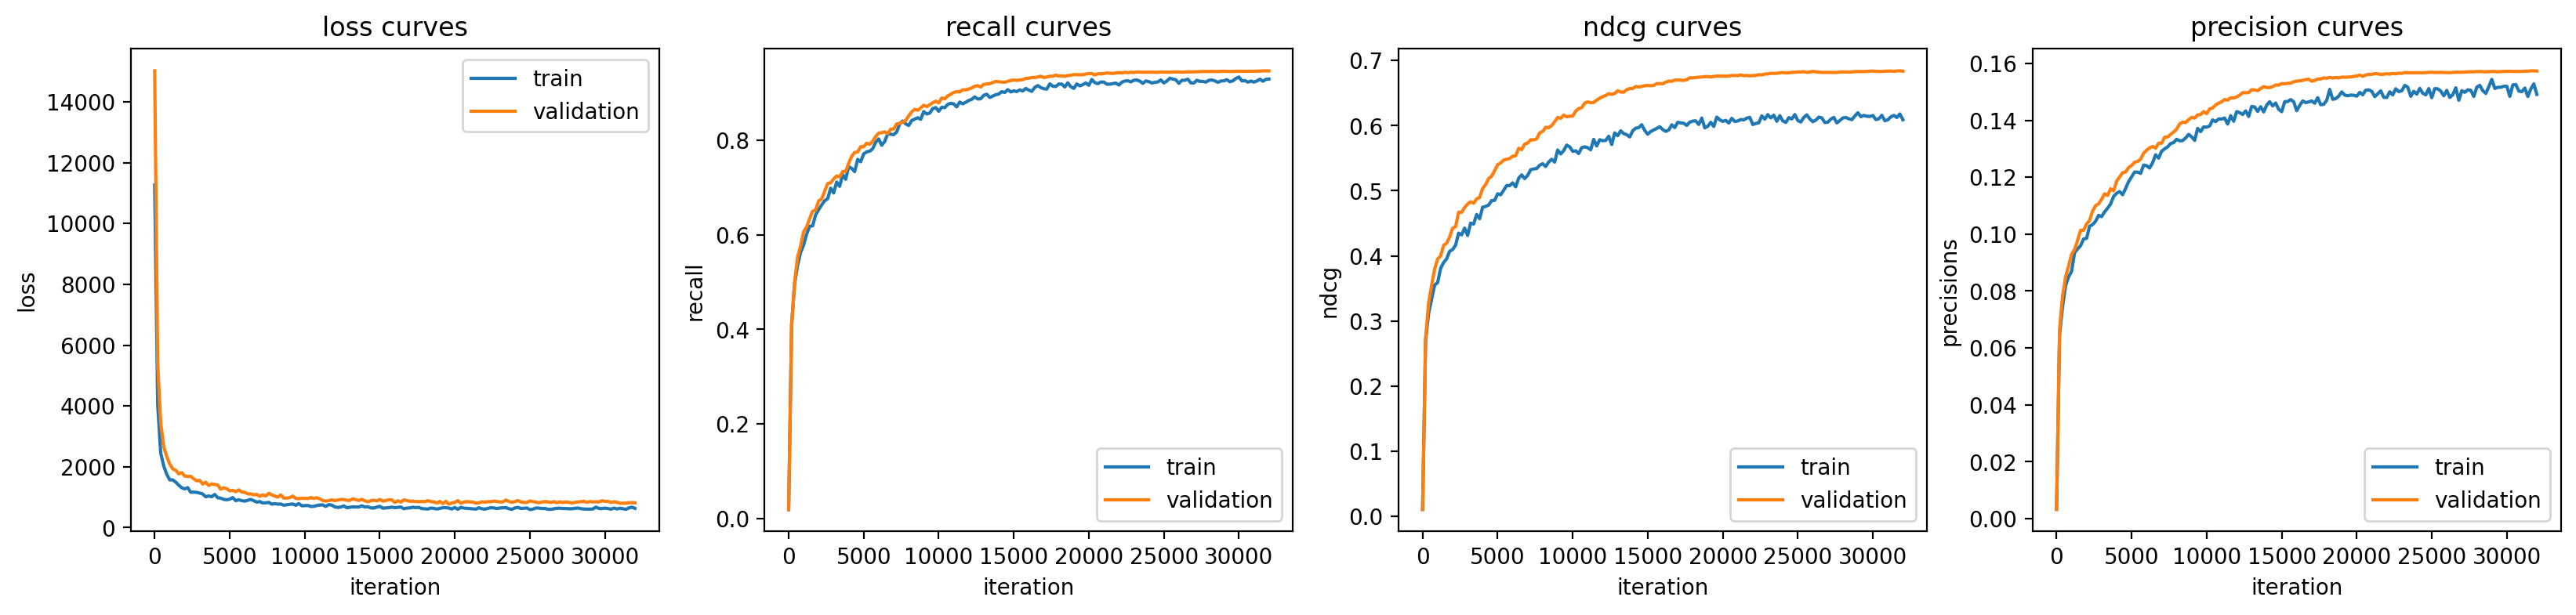

In [83]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20,4), dpi=200)

# ax[0].plot(iters, train_msg_losses, label='msg_train')
ax[0].plot(iters, train_losses, label='train')
ax[0].plot(iters, val_losses, label='validation')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('loss')
ax[0].set_title('loss curves')
ax[0].legend()

ax[1].plot(iters, train_recalls, label='train')
ax[1].plot(iters, val_recalls, label='validation')
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('recall')
ax[1].set_title('recall curves')
ax[1].legend()

ax[2].plot(iters, train_ndcgs, label='train')
ax[2].plot(iters, val_ndcgs, label='validation')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('ndcg')
ax[2].set_title('ndcg curves')
ax[2].legend()

ax[3].plot(iters, train_precisions, label='train')
ax[3].plot(iters, val_precisions, label='validation')
ax[3].set_xlabel('iteration')
ax[3].set_ylabel('precisions')
ax[3].set_title('precision curves')
ax[3].legend()

plt.show()

## Evaluation

In [84]:
model.eval()
user_pos_items = get_user_positive_items(edge_index)
id_to_course = {v: k for k, v in courseIds.items()}
user_pos_items[35]

[2120,
 2221,
 2222,
 1905,
 2223,
 2224,
 2225,
 2043,
 2226,
 2227,
 1931,
 2228,
 1910,
 2087,
 1923,
 2229,
 1960,
 2062,
 1979,
 1910,
 2230,
 1925,
 1926,
 2231]

In [85]:
def make_predictions(user, num_recs, only_new=True):
    e_u = model.users_emb_final[user]
    scores = model.items_emb_final @ e_u

    values, indices = torch.topk(scores, k=len(user_pos_items[user]) + num_recs)
    indices = [index.item() for index in indices]
    
    print(f"Here are classes user {user} has already taken:")
    for index in user_pos_items[user]:
        print(id_to_course[index])
    print()
    
    print(f'Here are the top recommended courses{" (* means already taken)" if not only_new else ""}:')
    i = 0
    not_yet_taken = 0
    while not_yet_taken < num_recs:
        if not only_new or indices[i]+num_users not in user_pos_items[user]:
            print(f"{id_to_course[indices[i]+num_users]} {'(*)' if indices[i]+num_users in user_pos_items[user] else ''}")
        if indices[i]+num_users not in user_pos_items[user]:
            not_yet_taken += 1
        i += 1

In [86]:
USER_ID = 7
NUM_RECS = 10

make_predictions(USER_ID, NUM_RECS)

Here are classes user 7 has already taken:
CHEM121
MED182
SYMSYS1
CHEM141
EMED127
HUMBIO154C
MUSIC12A
STS1

Here are the top recommended courses:
MUSIC160 
BIO84 
MED160 
SPANLANG1A 
HUMBIO2A 
PSYCH1 
SURG101 
HUMBIO171E 
THINK69 
CHEM33 


In [87]:
USER_ID = 1
NUM_RECS = 10

make_predictions(USER_ID, NUM_RECS)

Here are classes user 1 has already taken:
COMM172
ENGLISH50
PSYC135
PSYCH101
PSYCH195

Here are the top recommended courses:
PSYCH90 
PSYCH60 
PSYCH60A 
COMM186W 
PSYCH95 
PSYCH144 
HUMBIO163 
PSYCH80 
PSYC139 
PWR2RW 


In [88]:
USER_ID = 557
NUM_RECS = 10

make_predictions(USER_ID, NUM_RECS)

Here are classes user 557 has already taken:
CS106B
ESF17
MATH51
CHEM29N
COLLEGE102
CS103
DATASCI112
SYMSYS1
CS109
CS161
CS41
PATH51
CS107
CS148
PHYSICS21
SPECLANG150A
CLASSICS151
CS111
EMED127
PHYSICS23
SPECLANG150B
PWR2STA
SPECLANG150C
ARCHLGY151
CLASSICS21Q
CS198
PSYCH70
PSYCH95

Here are the top recommended courses:
PSYCH1 
CS106A 
ENGR76 
COLLEGE112 
PWR2IY 
CS221 
PHYSWELL12 
BIO150 
PHYSICS41 
CS224N 
